# Measuring the effectiveness of trainable quantum neural networks

To find out which of our designed circuits has any real, reproducable value, we will run each of them various times to see how they perform

In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_state_qsphere
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import *
import qiskit.quantum_info as qi

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output

import warnings
warnings.simplefilter('ignore')

import random
import time

random.seed(69069)
np.random.seed(69069)

In [2]:
#code to normalize features to a range of -1 and 1
from sklearn.preprocessing import MinMaxScaler

def normalize_data(data):
    return MinMaxScaler().fit_transform(data) * 2 - 1

#code to normalize features to a range of -pi and pi
def pifi_data(data):
    return MinMaxScaler().fit_transform(data) * 2 * np.pi - np.pi

#code to leave features as is
def as_is(data):
    return data


## IRIS tests
We will now create the circuits needed for the IRIS tests

In [3]:
#Arrays
circuits = []
datasets = []
accuracy = []

#Data
dataset = load_iris()
data = dataset['data']
targets = np.array(dataset['target'])

quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator'), shots=1024)

datasets.append(data)
datasets.append(normalize_data(data))
datasets.append(pifi_data(data))

n_features = len(data[0])

output_shape = 3
def parity(x):
    return '{:b}'.format(x).count('1') % 3

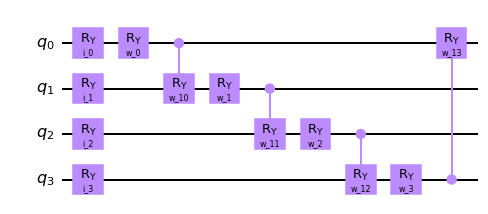

In [4]:
feature_map = QuantumCircuit(4)
ansatz = QuantumCircuit(4)
for i in range(len(data[1])):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.ry(Parameter('w_' + str(i)),i)
    ansatz.cry(Parameter('w_' + str(10+i)), i, (i+1)%4)


qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
qc.append(ansatz, range(4))

circuits.append(qc.decompose().copy())
circuits[-1].draw('mpl')

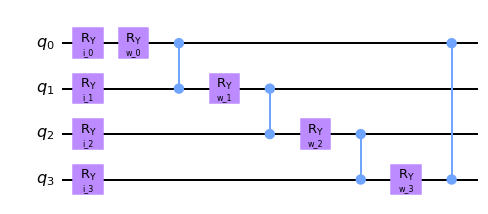

In [5]:
feature_map = QuantumCircuit(4)
ansatz = QuantumCircuit(4)
for i in range(len(data[1])):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.ry(Parameter('w_' + str(i)),i)
    ansatz.cz(i, (i+1)%4)


qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
qc.append(ansatz, range(4))

circuits.append(qc.decompose().copy())
circuits[-1].draw('mpl')

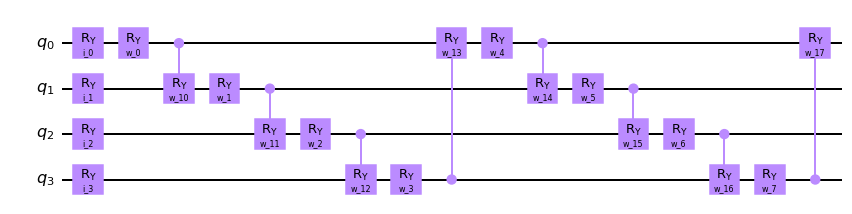

In [6]:
feature_map = QuantumCircuit(4)
ansatz = QuantumCircuit(4)
for i in range(len(data[1])):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.ry(Parameter('w_' + str(i)),i)
    ansatz.cry(Parameter('w_' + str(10+i)), i, (i+1)%4)


for i in range(len(data[1])):
    ansatz.ry(Parameter('w_' + str(i+4)),i)
    ansatz.cry(Parameter('w_' + str(10+i+4)), i, (i+1)%4)

qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
qc.append(ansatz, range(4))

circuits.append(qc.decompose().copy())
circuits[-1].draw('mpl')

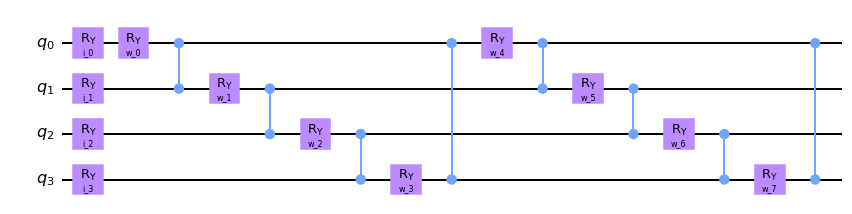

In [7]:
feature_map = QuantumCircuit(4)
ansatz = QuantumCircuit(4)
for i in range(len(data[1])):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.ry(Parameter('w_' + str(i)),i)
    ansatz.cz(i, (i+1)%4)


for i in range(len(data[1])):
    ansatz.ry(Parameter('w_' + str(i+4)),i)
    ansatz.cz(i, (i+1)%4)

qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
qc.append(ansatz, range(4))

circuits.append(qc.decompose().copy())
circuits[-1].draw('mpl')

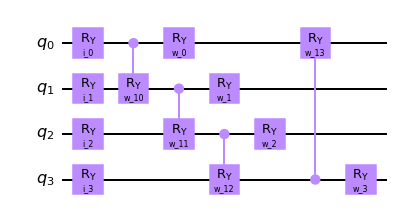

In [8]:
feature_map = QuantumCircuit(4)
ansatz = QuantumCircuit(4)
for i in range(len(data[1])):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.cry(Parameter('w_' + str(10+i)), i, (i+1)%4)
    ansatz.ry(Parameter('w_' + str(i)),i)


qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
qc.append(ansatz, range(4))

circuits.append(qc.decompose().copy())
circuits[-1].draw('mpl')

In [9]:
feature_map = QuantumCircuit(1)
ansatz = QuantumCircuit(1)
for i in range(len(data[1])):
    feature_map.ry(Parameter('i_' + str(i)),0)
    ansatz.ry(Parameter('w_' + str(i)),0)


qc = QuantumCircuit(1)
qc.append(feature_map, range(1))
qc.append(ansatz, range(1))

#NOT USED HERE BECAUSE CAN ONLY CLASSIFY 2 CLASSES
#circuits.append(qc.decompose().copy())
#circuits[-1].draw('mpl')

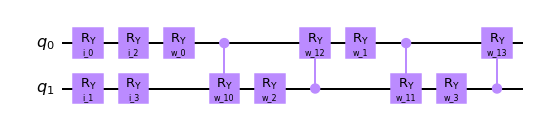

In [10]:
feature_map = QuantumCircuit(2)
ansatz = QuantumCircuit(2)
for i in range(2):
    feature_map.ry(Parameter('i_' + str(i)),i)
    feature_map.ry(Parameter('i_' + str(i+2)),i)
    ansatz.ry(Parameter('w_' + str(i)), 0)
    ansatz.cry(Parameter('w_' + str(10+i)), 0, 1)
    ansatz.ry(Parameter('w_' + str(i+2)), 1)
    ansatz.cry(Parameter('w_' + str(10+i+2)), 1, 0)


qc = QuantumCircuit(2)
qc.append(feature_map, range(2))
qc.append(ansatz, range(2))

circuits.append(qc.decompose().copy())
circuits[-1].draw('mpl')

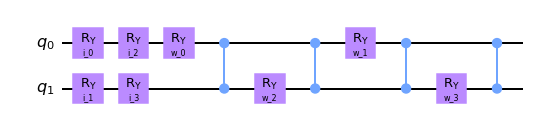

In [11]:
feature_map = QuantumCircuit(2)
ansatz = QuantumCircuit(2)
for i in range(2):
    feature_map.ry(Parameter('i_' + str(i)),i)
    feature_map.ry(Parameter('i_' + str(i+2)),i)
    ansatz.ry(Parameter('w_' + str(i)), 0)
    ansatz.cz(0, 1)
    ansatz.ry(Parameter('w_' + str(i+2)), 1)
    ansatz.cz(1, 0)


qc = QuantumCircuit(2)
qc.append(feature_map, range(2))
qc.append(ansatz, range(2))

circuits.append(qc.decompose().copy())
circuits[-1].draw('mpl')

### Functions needed for training

In [20]:
def fit_and_score(circuit_classifier, features, targets, random_state = 69069):
    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=1-3/4, random_state=random_state)

    # fit classifier to data
    circuit_classifier.fit(X_train, y_train)
    score_train =  circuit_classifier.score(X_train, y_train)
    score_test =  circuit_classifier.score(X_test, y_test)
    print("Mean Accuracy training: " + str(score_train))
    print("Mean Accuracy testing: " + str(score_test))
    return score_train, score_test

def get_classifier(circuit):
    circuit_qnn = CircuitQNN(circuit=circuit,    
                         input_params=circuit.parameters[0:n_features],
                         weight_params=circuit.parameters[n_features:],
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

    # construct classifier
    return NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                                optimizer=COBYLA())

In [21]:
#so
dataset_runs = []

for data in datasets:
    display(print("Testing dataset"))
    for circuit in circuits:
        training_data = []
        testing_data = []
        for i in range(10):
            display(print('run: ' + str(i+1)))
            classifier = get_classifier(circuit.copy())
            score_train, score_test = fit_and_score(classifier, data, targets)
            training_data.append(score_train)
            testing_data.append(score_test)
        display(print('Circuit done'))
    dataset_runs.append([training_data, testing_data])

Testing dataset


None

run: 1


None

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 